# End-to-End FINN Flow for ResNet (test version)
-----------------------------------------------------------------

In this notebook, we will go through the FINN steps needed to take a ResNet all the way down to a heterogeneous streaming dataflow accelerator running on the FPGA. 

In [1]:
from qonnx.core.modelwrapper import ModelWrapper
import numpy as np

from qonnx.transformation.fold_constants import FoldConstants

from qonnx.transformation.general import (
    ConvertSubToAdd,
    ConvertDivToMul,
    GiveReadableTensorNames,
    GiveUniqueNodeNames,
    SortGraph,
    RemoveUnusedTensors,
    GiveUniqueParameterTensors,
    RemoveStaticGraphInputs,
    ApplyConfig,
)

from finn.transformation.streamline.absorb import (
    AbsorbScalarMulAddIntoTopK,
    AbsorbAddIntoMultiThreshold,
    AbsorbMulIntoMultiThreshold,
    FactorOutMulSignMagnitude,
    Absorb1BitMulIntoMatMul,
    Absorb1BitMulIntoConv,
    AbsorbConsecutiveTransposes,
    AbsorbTransposeIntoMultiThreshold,
    AbsorbSignBiasIntoMultiThreshold,
)

from finn.transformation.streamline.collapse_repeated import (
    CollapseRepeatedAdd,
    CollapseRepeatedMul,
)

from finn.transformation.streamline.reorder import (
    MoveAddPastMul,
    MoveScalarMulPastMatMul,
    MoveScalarAddPastMatMul,
    MoveAddPastConv,
    MoveScalarMulPastConv,
    MoveScalarLinearPastInvariants,
    MoveMaxPoolPastMultiThreshold,
)

from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from finn.transformation.streamline.sign_to_thres import ConvertSignToThres
from qonnx.transformation.batchnorm_to_affine import BatchNormToAffine

# just for not linear
from finn.transformation.streamline.reorder import (
    MoveLinearPastEltwiseAdd,
    MoveLinearPastFork,
)

from qonnx.transformation.double_to_single_float import DoubleToSingleFloat
from qonnx.transformation.remove import RemoveIdentityOps
from qonnx.core.datatype import DataType

from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.insert_topk import InsertTopK
import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul

from finn.builder.build_dataflow_config import (
    DataflowBuildConfig,
    ShellFlowType,
)

from finn.transformation.fpgadataflow.prepare_ip import PrepareIP
from finn.transformation.fpgadataflow.hlssynth_ip import HLSSynthIP
from finn.transformation.fpgadataflow.replace_verilog_relpaths import (
    ReplaceVerilogRelPaths,
)

from finn.transformation.move_reshape import RemoveCNVtoFCFlatten

from qonnx.util.config import extract_model_config_to_json
from finn.transformation.fpgadataflow.set_fifo_depths import (
    InsertAndSetFIFODepths,
    RemoveShallowFIFOs,
)
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO
from qonnx.custom_op.registry import getCustomOp

from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)

In [2]:
def step_resnet_tidy(onnx_file, store_name):
    model = ModelWrapper(onnx_file)
    model = model.transform(GiveUniqueParameterTensors())    
    model = model.transform(InferShapes())
    model = model.transform(FoldConstants())
    model = model.transform(RemoveStaticGraphInputs())
    model = model.transform(GiveUniqueNodeNames())
    model = model.transform(GiveReadableTensorNames())
    model = model.transform(InferDataTypes())
    model = model.transform(InsertTopK())
    model = model.transform(InferShapes())
    model = model.transform(GiveUniqueNodeNames())
    model = model.transform(GiveReadableTensorNames())
    model = model.transform(InferDataTypes())
    model.save(f'{store_name}_tidy.onnx')
    return model

In [112]:
def step_resnet_streamline_linear(model):
    streamline_transformations = [
        AbsorbSignBiasIntoMultiThreshold(), # added from https://github.com/Xilinx/finn/issues/337
        AbsorbScalarMulAddIntoTopK(),       # before MoveAddPastMul to avoid int->float
        ConvertSubToAdd(),
        ConvertDivToMul(),
        RemoveIdentityOps(),
        CollapseRepeatedMul(),
        BatchNormToAffine(),
        ConvertSignToThres(),
        MoveAddPastMul(),
        MoveScalarAddPastMatMul(),
        MoveAddPastConv(),
        MoveScalarMulPastMatMul(),
        MoveScalarMulPastConv(),
        MoveScalarLinearPastInvariants(),
        MoveAddPastMul(),
        CollapseRepeatedAdd(),
        CollapseRepeatedMul(),
        AbsorbAddIntoMultiThreshold(),
        FactorOutMulSignMagnitude(),
        MoveMaxPoolPastMultiThreshold(),
        AbsorbMulIntoMultiThreshold(),
        Absorb1BitMulIntoMatMul(),
        Absorb1BitMulIntoConv(),
        RoundAndClipThresholds(),
    ]
    for trn in streamline_transformations:
        model = model.transform(trn)
        model = model.transform(GiveUniqueNodeNames())
    return model


def step_resnet_streamline_nonlinear(model):
    streamline_transformations = [
        MoveLinearPastEltwiseAdd(),
        MoveLinearPastFork(),
    ]
    for trn in streamline_transformations:
        model = model.transform(trn)
        model = model.transform(GiveUniqueNodeNames())
    return model


def step_resnet_streamline(model, store_name):

    for iter_id in range(4):
        model = step_resnet_streamline_linear(model)
        model = step_resnet_streamline_nonlinear(model)

        # big loop tidy up
        model = model.transform(RemoveUnusedTensors())
        model = model.transform(GiveReadableTensorNames())
        model = model.transform(InferDataTypes())
        model = model.transform(SortGraph())

    model = model.transform(DoubleToSingleFloat())
    model.save(f'{store_name}_streamlined.onnx')
    return model

In [113]:
def step_resnet_convert_to_hls(model, store_name):
    mem_mode = "decoupled"
    
    model.set_tensor_datatype(model.graph.input[0].name, DataType["UINT8"])
    model = model.transform(InferDataLayouts())

    model = model.transform(DoubleToSingleFloat())
    model = model.transform(InferDataTypes())
    model = model.transform(SortGraph())

    to_hls_transformations = [
        to_hls.InferAddStreamsLayer,
        LowerConvsToMatMul,
        to_hls.InferChannelwiseLinearLayer,
        to_hls.InferPool_Batch,
        AbsorbTransposeIntoMultiThreshold,
        RoundAndClipThresholds,
        to_hls.InferBinaryMatrixVectorActivation, # added
        to_hls.InferQuantizedMatrixVectorActivation,
        to_hls.InferThresholdingLayer,
        AbsorbConsecutiveTransposes,
        to_hls.InferConvInpGen,
        to_hls.InferDuplicateStreamsLayer,
        to_hls.InferLabelSelectLayer,
    ]
    for trn in to_hls_transformations:
        if trn ==  to_hls.InferQuantizedMatrixVectorActivation or trn == to_hls.InferBinaryMatrixVectorActivation:
            model = model.transform(trn(mem_mode))
        else:
            model = model.transform(trn())
        model = model.transform(InferDataLayouts())
        model = model.transform(GiveUniqueNodeNames())
        model = model.transform(InferDataTypes())
        
    
    model = model.transform(RemoveCNVtoFCFlatten())
    
    parent_model = model.transform(CreateDataflowPartition())
    sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
    sdp_node = getCustomOp(sdp_node)
    dataflow_model_filename = sdp_node.get_nodeattr("model")
    # save the dataflow partition with a different name for easier access
    model = ModelWrapper(dataflow_model_filename)
    
    model = model.transform(GiveReadableTensorNames())
    model = model.transform(RemoveUnusedTensors())
    model = model.transform(SortGraph())
    model.save(f'{store_name}_dataflow.onnx')
    
    return model

In [120]:
def step_resnet_set_config(model, store_name):

#     model = model.transform(InsertDWC())
#     model = model.transform(InsertFIFO(create_shallow_fifos=True))
    model = model.transform(GiveUniqueNodeNames())
    model = model.transform(GiveReadableTensorNames())
    
    layers = model.get_nodes_by_op_type("MatrixVectorActivation")
    # each tuple is (PE, SIMD, in_fifo_depth) for a layer
    print(len(layers))
    folding = [
    #     (16, 3, 128),
    #     (16, 4, 128),
    #     (16, 4, 128),
    #     (16, 8, 64),
    #     (16, 16, 64),
    #     (16, 32, 16),
    #     (16, 32, 4),
    #     (1, 8, 128),
    #     (8, 1, 3),
        (16, 1 , 32), #0
        (2, 4, 32), #1
        (2, 4, 32), #2
        (2, 4, 32), #3
        (2, 4, 32), #4
        (2, 4, 32), #5
        (1, 4, 32), #6
        (1, 4, 32), #7
        (1, 4, 32), #8
#         (1, 4, 32), #9
#         (8, 1 , 32), #0
#         (2, 2, 32), #1
#         (2, 2, 32), #2
#         (2, 2, 32), #3
#         (2, 2, 32), #4
#         (1, 2, 32), #5
#         (1, 2, 32), #6
#         (1, 2, 32), #7
#         (1, 2, 32), #8
    ]
    for l, (pe, simd, ififodepth) in zip(layers, folding):
        l_inst = getCustomOp(l)
        l_inst.set_nodeattr("PE", pe)
        l_inst.set_nodeattr("SIMD", simd)
        l_inst.set_nodeattr("inFIFODepth", ififodepth)
#         l_inst.set_nodeattr("ram_style", ramstyle)

    # use same SIMD values for the sliding window operators
    swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator")
    print(len(swg_layers))
    
#     folding = folding[0:5]+folding[6:10]+folding[11:15]+folding[16:]
#     folding = folding[0:3]+folding[4:6]+folding[7:9]+folding[10:-2]
#     folding = folding[0:1]+folding[2:4]+folding[5:7]+folding[8:]
    folding = folding[0:3]+folding[4:6]+folding[7:]
    print(len(folding))
    for i in range(len(swg_layers)):
        swg_inst = getCustomOp(swg_layers[i])
        simd = folding[i][1]
        swg_inst.set_nodeattr("SIMD", simd)
        
    model = model.transform(RemoveShallowFIFOs())


    # after FIFOs are ready to go, call PrepareIP and HLSSynthIP again
    # this will only run for the new nodes (e.g. FIFOs and DWCs)

#     model = model.transform(
#         PrepareIP("Pynq-Z2", 10)
#     )
#     model = model.transform(HLSSynthIP())
#     model = model.transform(ReplaceVerilogRelPaths())

    model = model.transform(GiveUniqueNodeNames())
    model.save(f'{store_name}_folded.onnx')
    
    return model

In [121]:
from finn.util.basic import make_build_dir
from finn.util.visualization import showInNetron
import os

# initialize
build_dir = os.environ["FINN_BUILD_DIR"]
print(build_dir)
if not os.path.exists(build_dir):
    os.makedirs(build_dir)

# wrapper onnx
# onnx_file = "finn_resnet.onnx"
# onnx_file = "finn_resnet10.onnx"
# onnx_file = "finn_resnet8_gray.onnx"
onnx_file = "finn_resnet8.onnx"

ver = "6"
w_bit = "4"
a_bit = "4"
store_name = os.path.join(build_dir,f'resnet_v{ver}_w{w_bit}a{a_bit}')

model = step_resnet_tidy(os.path.join(build_dir,onnx_file), store_name)
model = step_resnet_streamline(model, store_name)
model = step_resnet_convert_to_hls(model, store_name)
model = step_resnet_set_config(model, store_name)

/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/build
9
7
7


## Hardware Generation

In [122]:
test_pynq_board = "Pynq-Z2"
# test_pynq_board = "KV260"
target_clk_ns = 10

from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
model = ModelWrapper(f'{store_name}_folded.onnx')
model = model.transform(ZynqBuild(platform = test_pynq_board, period_ns = target_clk_ns))

/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/src/finn/transformation/fpgadataflow/floorplan.py:108: UserWarning: 60 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:189: UserWarning: Overriding input FIFO depth to 32
  warnings.warn("Overriding input FIFO depth to 32")
/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:236: UserWarning: Overriding output FIFO depth to 32
  warnings.warn("Overriding output FIFO depth to 32")


After the `ZynqBuild` we run one additional transformation to generate a PYNQ driver for the accelerator.

In [123]:
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
model = model.transform(MakePYNQDriver("zynq-iodma"))

In [124]:
model.save(f'{store_name}_synth.onnx')

## 5. Deployment and Remote Execution

Now that we're done with the hardware generation, we can copy the necessary files onto our PYNQ board.

**Make sure you've [set up the SSH keys for your PYNQ board](https://finn-dev.readthedocs.io/en/latest/getting_started.html#pynq-board-first-time-setup) before executing this step.**

In [125]:
import os

# set up the following values according to your own environment
# FINN will use ssh to deploy and run the generated accelerator
# ip = "192.168.2.99"
# username = os.getenv("PYNQ_USERNAME", "xilinx")
# password = os.getenv("PYNQ_PASSWORD", "xilinx")
# port = os.getenv("PYNQ_PORT", 22)
# target_dir = os.getenv("PYNQ_TARGET_DIR", "/home/xilinx/finn_cnv_end2end_example")
# # set up ssh options to only allow publickey authentication
# options = "-o PreferredAuthentications=publickey -o PasswordAuthentication=no"

# # test access to PYNQ board
# ! ssh {options} {username}@{ip} -p {port} cat /var/run/motd.dynamic

ip = "192.168.1.60"   # your current build (not pynq) machine ip
username = 'yhp'    # your current build (not pynq) machine account
password = 'x' # dummy, don't modify
port = 22  # your current build (not pynq) machine ip port
target_dir = os.getenv("PYNQ_TARGET_DIR", "/home/xilinx/finn_cnv_end2end_example")
print(target_dir)

/home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp


In [126]:
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ

model = ModelWrapper(f'{store_name}_synth.onnx')
model = model.transform(DeployToPYNQ(ip, port, username, password, target_dir))
model.save(f'{store_name}_deploy.onnx')

Please manually copy and paste the following command in the remote pynq jupter notebook.
mkdir -p /home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp
scp -P22 -r yhp@192.168.1.60:/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/build/pynq_deployment_4va4zw4y /home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp


In [127]:
target_dir_pynq = target_dir + "/" + model.get_metadata_prop("pynq_deployment_dir").split("/")[-1]
target_dir_pynq

'/home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp/pynq_deployment_4va4zw4y'

In [128]:
# ! ssh {options} {username}@{ip} -p {port} 'ls -l {target_dir_pynq}'

We only have two more steps to be able to remotely execute the deployed bitfile with some test data from the CIFAR-10 dataset. Let's load up some test data that comes bundled with FINN -- *and before you ask, that's supposed to be a cat (CIFAR-10 class number 3)*.

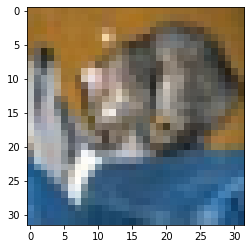

In [129]:
import pkg_resources as pk
import matplotlib.pyplot as plt
import numpy as np

fn = pk.resource_filename("finn.qnn-data", "cifar10/cifar10-test-data-class3.npz")
x = np.load(fn)["arr_0"]
x = x.reshape(3, 32,32).transpose(1, 2, 0)
plt.imshow(x)

Recall that we partitioned our original network into a parent graph that contained the non-synthesizable nodes and a child graph that contained the bulk of the network, which we turned into a bitfile. The only operator left outside the FPGA partition was a `Transpose` to convert NCHW images into NHWC ones. Thus, we can skip the execution in the parent as long as we ensure our image has the expected data layout, which we have done above.

In [130]:
import numpy as np
from finn.core.onnx_exec import execute_onnx

model = ModelWrapper(f'{store_name}_deploy.onnx')
iname = model.graph.input[0].name
oname = model.graph.output[0].name
ishape = model.get_tensor_shape(iname)
input_dict = {iname: x.astype(np.float32).reshape(ishape)}
ret = execute_onnx(model, input_dict, True)

Please manually copy and paste the following command in the remote pynq jupter notebook.
============== copy input to PYNQ board ================
scp -P22 -r yhp@192.168.1.60:/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/build/pynq_deployment_4va4zw4y/input.npy /home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp/pynq_deployment_4va4zw4y

============== use platform attribute for correct remote execution ================
cd /home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp/pynq_deployment_4va4zw4y; python3 driver.py --exec_mode=execute --batchsize=1 --bitfile=resizer.bit --inputfile=input.npy --outputfile=output.npy --platform=zynq-iodma

============== copy generated output to local ==========================
scp -P22  /home/xilinx/jupyter_notebooks/FINN/finn_dev_yhp/pynq_deployment_4va4zw4y/output.npy yhp@192.168.1.60:/home/yhp/Documents/Class/111-1_HLS/course-lab_finn/course-lab_finn/FINN_v0.8_lab_packv2/finn/build/pynq_deployment_4va4zw4y 

In [ ]:
ret[oname]

We see that the network correctly predicts this as a class 3 ("cat"). 

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

All the command line prompts here are meant to be executed with `sudo` on the PYNQ board, so we'll use a workaround (`echo password | sudo -S command`) to get that working from this notebook running on the host computer.

**Ensure that your PYNQ board has a working internet connecting for the next steps, since some there is some downloading involved.**

To validate the accuracy, we first need to install the [`dataset-loading`](https://github.com/fbcotter/dataset_loading) Python package to the PYNQ board. This will give us a convenient way of downloading and accessing the MNIST dataset.


Command to execute on PYNQ:

```pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading```

In [17]:
# ! ssh {options} -t {username}@{ip} -p {port} 'echo {password} | sudo -S pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading'
print("Please paste the below command into pynq terminal")
print("=========================================================")
print("su xilinx")
print("sudo python3 -m pip install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading")

Please paste the below command into pynq terminal
su xilinx
sudo python3 -m pip install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading


We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the CIFAR-10 dataset.

Command to execute on PYNQ:

`python3.6 validate.py --dataset cifar10 --batchsize 1000`

In [18]:
# ! ssh {options} -t {username}@{ip} -p {port} 'cd {target_dir_pynq}; echo {password} | sudo -S python3.6 validate.py --dataset cifar10 --batchsize 1000'
print("Please paste the below command into pynq terminal")
print("=========================================================")
print("su ")
print("python3 validate.py --dataset cifar10 --batchsize 1000")

Please paste the below command into pynq terminal
su 
python3 validate.py --dataset cifar10 --batchsize 1000


We see that the final top-1 accuracy is 84.19%, which is very close to the 84.22% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq). 